In [2]:
from collections import defaultdict

import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [3]:
!pip install transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

     |████████████████████████████████| 3.1 MB 4.3 MB/s 
     |████████████████████████████████| 596 kB 46.7 MB/s 
     |████████████████████████████████| 59 kB 6.7 MB/s 
     |████████████████████████████████| 3.3 MB 56.4 MB/s 
     |████████████████████████████████| 895 kB 56.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
# ClassApproximation = 1

In [7]:
df_train = pd.read_csv("./train.tsv", delimiter="\t", header=None, index_col=False)
df_train["queries"] = df_train[0]
df_train["labels"] = df_train[1]

df_train = df_train.drop(columns=[0])
df_train = df_train.drop(columns=[1])
df_train.head()

# if ClassApproximation:
#   classes = {'0.0','0.2','0.4', '0.6', '0.8', '1.0'}
#   for j in range(len(df_train["labels"])):
#     if str(df_train["labels"][j]) not in classes:
#       if df_train["labels"][j] > 0.3 and df_train["labels"][j] < 0.4:
#         df_train["labels"][j] = 0.4
#       if df_train["labels"][j] < 0.7 and df_train["labels"][j] > 0.6:
#         df_train["labels"][j] = 0.6
#       df_train["labels"][j] = round(df_train["labels"][j], 1)
#       if df_train["labels"][j] == 0.5:
#         df_train["labels"][j] = 0.4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarn

In [8]:
count = 0
classes = {'0.0','0.2','0.4', '0.6', '0.8', '1.0'}
for j in range(len(df_train["labels"])):
  if str(df_train["labels"][j]) not in classes:
    count +=1
print(count)

0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


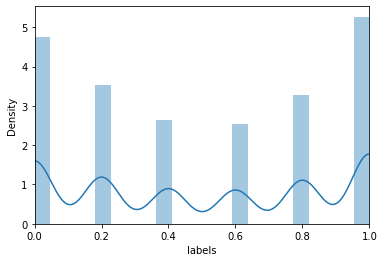

In [9]:
sns.distplot(df_train["labels"])
plt.xlim([0, 1]);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


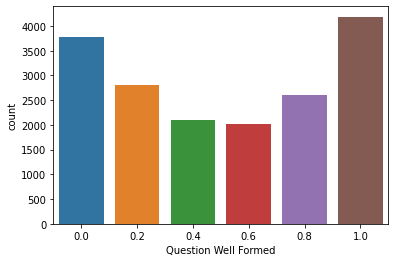

In [10]:
sns.countplot(df_train["labels"])
plt.xlabel('Question Well Formed');

In [11]:
df_val = pd.read_csv("./dev.tsv", delimiter="\t", header=None, index_col=False)
df_val["queries"] = df_val[0]
df_val["labels"] = df_val[1]

df_val = df_val.drop(columns=[0])
df_val = df_val.drop(columns=[1])
df_val.head()

# if ClassApproximation:
#   classes = {'0.0','0.2','0.4', '0.6', '0.8', '1.0'}
#   for j in range(len(df_val["labels"])):
#     if str(df_val["labels"][j]) not in classes:
#       if df_val["labels"][j] > 0.3 and df_val["labels"][j] < 0.4:
#         df_val["labels"][j] = 0.4
#       if df_val["labels"][j] < 0.7 and df_val["labels"][j] > 0.6:
#         df_val["labels"][j] = 0.6
#       df_val["labels"][j] = round(df_val["labels"][j], 1)
#       if df_val["labels"][j] == 0.5:
#         df_val["labels"][j] = 0.4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyW

In [12]:
df_test = pd.read_csv("./test.tsv", delimiter="\t", header=None, index_col=False)
df_test["queries"] = df_test[0]
df_test["labels"] = df_test[1]

df_test = df_test.drop(columns=[0])
df_test = df_test.drop(columns=[1])
df_test.head()

,queries,labels
0,Interesting facts about Egypt ?,0.4
1,What is thais in phuket famous for ?,0.0
2,What places have the oligarchy government ?,1.0
3,Where is the radiator fan relay located at 97 ...,0.4
4,When was the first helicopters built ?,0.4


In [13]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Choosing maximum token length

In [14]:
token_lens = []
for txt in df_train["queries"]:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


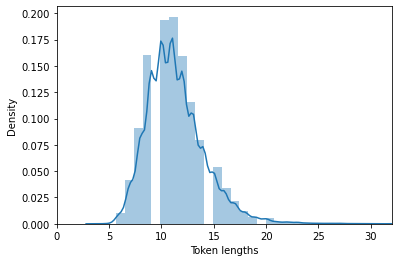

In [15]:
sns.distplot(token_lens)
plt.xlim([0, 32]);
plt.xlabel('Token lengths');

In [16]:
del token_lens

In [17]:
MAX_LEN = 32
BATCH_SIZE = 32
EPOCHS = 2
mylearning_rate = 2e-5

### Dataset Class

In [18]:
class QueryDataset(Dataset):
    def __init__(self, queries, labels, tokenizer, max_len):
        super().__init__()

        self.queries = queries
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)
    

    def __getitem__(self, idx):
        query = self.queries[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            query,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'query_text': query,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [19]:
df_train.shape, df_val.shape

((17500, 2), (3750, 2))

In [20]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = QueryDataset(
        queries=df["queries"].to_numpy(),
        labels=df["labels"].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        dataset,
        batch_size=batch_size
    )

In [21]:

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

### Sample data

In [22]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['query_text', 'input_ids', 'attention_mask', 'label'])

In [23]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['label'].shape)

torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32])


In [24]:
class QueryClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.bert = bert_model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [25]:
NUM_CLASSES = 6
model = QueryClassifier(NUM_CLASSES)
model = model.to(device)

In [26]:
optimizer = AdamW(model.parameters(), lr=mylearning_rate, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [27]:
def train(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for index, batch in enumerate(data_loader):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    targets = batch["label"].to(device)

    # forward pass
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    # loss
    loss = loss_fn(outputs, targets)

    # accuracy
    _, preds = torch.max(outputs, dim=1)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    # backward pass
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    # optimization
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    if index % 100 == 0:
        print(f"processed {index} batches")
  return correct_predictions.double() / n_examples, np.mean(losses)

In [28]:
def evaluation(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      targets = batch["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [29]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
torch.cuda.empty_cache()

In [31]:
history = defaultdict(list)
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.time()

    train_acc, train_loss = train(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    val_acc, val_loss = evaluation(model, val_data_loader, loss_fn, device, len(df_val))
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model, "./model.pth")
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


processed 0 batches
processed 100 batches
processed 200 batches
processed 300 batches
processed 400 batches
processed 500 batches
Epoch: 01 | Epoch Time: 1m 17s
	Train Loss: 0.435 | Train Acc: 77.98%
	 Val. Loss: 0.370 |  Val. Acc: 81.71%
processed 0 batches
processed 100 batches
processed 200 batches
processed 300 batches
processed 400 batches
processed 500 batches
Epoch: 02 | Epoch Time: 1m 17s
	Train Loss: 0.265 | Train Acc: 88.29%
	 Val. Loss: 0.424 |  Val. Acc: 79.23%


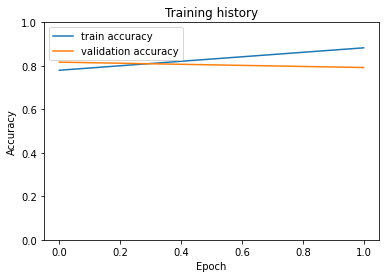

In [32]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [33]:
model = torch.load("./model.pth")
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
test_acc, test_loss = evaluation(model, test_data_loader, loss_fn, device, len(df_test))
print(f'\t Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


	 Test. Loss: 0.376 |  Test. Acc: 80.70%


In [34]:
def inference(query_text, model, device):
    encoded_query = tokenizer.encode_plus(
        query_text,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoded_query['input_ids'].to(device)
    attention_mask = encoded_query['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    print(f'query text: {query_text}')
    print(f'label  : {prediction}')
    return prediction

In [35]:
test_query = "Do you hate this movie?"
inference(test_query, model, device)

query text: Do you hate this movie?
label  : tensor([1], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


tensor([1], device='cuda:0')